<a href="https://colab.research.google.com/github/agustinivandinocco-python/pythonpracticateoria/blob/main/Colab/clase_10_2025_ML_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje NO supervisado

## Reduccion de dimensionalidad

### Ejemplo extremadamente simple para entender el concepto

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


#plt.style.use('seaborn')
#mpl.rcParams['axes.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7



data = yf.download('^GSPC', auto_adjust=True)
cruces = [(5,10),(5,20),(10,15),(10,20),(10,30),(15,25),(20,30),(30,50),(40,70),(50,80),
          (50,100),(50,200),(60,120),(60,250),(80,150),(100,200),(100,300), (150,300), (200,300)]

for cruce in cruces:
    fast, slow = cruce[0], cruce[1]
    data[f'c_{fast}_{slow}'] = data.Close.rolling(fast).mean() / data.Close.rolling(slow).mean() - 1

data['target'] = data.Close.shift(-100) / data.Close - 1
data.dropna(inplace=True)
features = data.iloc[:,-len(cruces):-1]
target = data.iloc[:,-1]

[*********************100%***********************]  1 of 1 completed


,0
Correlacion,0.030068


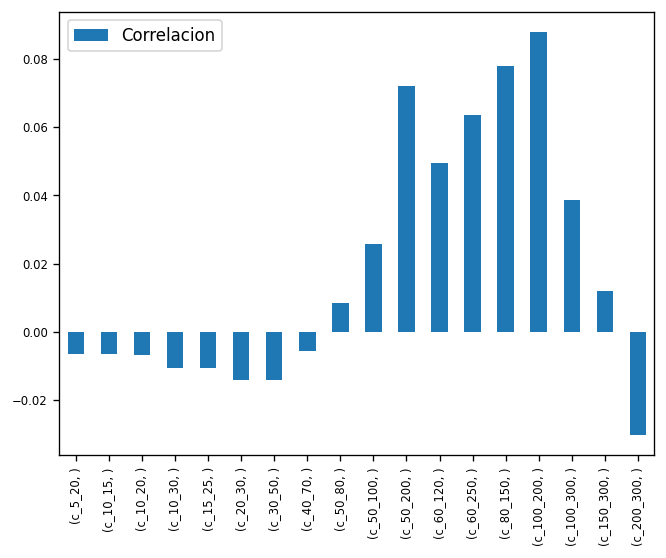

In [ ]:
corrs = {}
for feature in features.columns:
    corrs[feature] = features[feature].corr(target)

pd.DataFrame([corrs], index=['Correlacion']).T.plot(kind='bar')

pd.DataFrame([corrs], index=['Correlacion']).T.abs().mean()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


from sklearn.decomposition import PCA

# Creamos una instancia de PCA
pca = PCA()

# Entrenamos y aplicamos PCA a los features estandarizados
pca_features = pca.fit_transform(scaled_features)

# Calculamos la cantidad de componentes necesarios para explicar el 95% de la varianza
variance = pca.explained_variance_ratio_.cumsum()
n_components = (variance<0.8).sum()+1

print(f'{n_components} componentes explican el 90% de la varianza')

# Finalmente, aplicamos PCA con el número de componentes óptimos
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(scaled_features)


3 componentes explican el 90% de la varianza


In [ ]:
new_features = pd.DataFrame(pca_features)

corrs = {}
for feature in new_features.columns:
    corrs[feature] = new_features[feature].corr(target.reset_index(drop=True))

display(pd.DataFrame([corrs], index=['Correlacion']))
pd.DataFrame([corrs], index=['Correlacion']).T.abs().mean()

,0,1,2
Correlacion,0.037874,-0.034655,-0.007681


,0
Correlacion,0.026737


### Ejemplo del notebook complementario del algoritmo del Arbol de Decision clase anterior

In [ ]:
smas = ((30, 100), (50, 200), (70, 300))
ventana = 250

tickers = ['LMT', 'SO', 'BAC', 'ABT', 'IBM', 'MCD', 'TMO', 'WFC', 'COST', 'TSLA', 'NFLX', 'BA', 'AMAT', 'UNH', 'EXC', 'T',
 'C', 'GD', 'SPG', 'INTU', 'AXP', 'GE', 'HD', 'CVX', 'DHR', 'LUV', 'TXN', 'LLY', 'SBUX', 'CVS', 'TGT', 'PEP',
 'GOOGL', 'HON', 'JPM', 'QCOM', 'CMCSA', 'VZ', 'FDX', 'PG', 'NEM', 'AAPL', 'LOW', 'DIS', 'SLB', 'PM', 'CSX',
 'KO', 'GS', 'MET', 'NSC', 'AMGN', 'MMM', 'META', 'JNJ', 'AMZN', 'INTC', 'V', 'NEE', 'WMT', 'CSCO', 'GM', 'COP',
 'CAT', 'ADBE', 'ORCL', 'CME', 'PFE', 'OXY', 'MA', 'MSFT', 'UPS', 'ADP', 'MS', 'CRM', 'UNP', 'MO', 'EMR', 'NVDA',
 'GILD', 'BMY', 'ABBV', 'NKE', 'XOM', 'MRK', 'MDLZ']

df = yf.download(tickers, start='2000-01-01',auto_adjust=True)
spy = yf.download('SPY', start='2000-01-01', auto_adjust=True)
vix = yf.download('^VIX', start='2000-01-01', auto_adjust=True)

dfs_train, dfs_test = [], []
for ticker in tickers:
    data = df['Close'][ticker].to_frame()
    data.columns = ['Close']
    dif = data['Close'].diff()
    RSI_CONS = 50
    win = pd.DataFrame(np.where(dif > 0, dif, 0))
    loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
    ema_win = win.ewm(alpha=1/RSI_CONS).mean()
    ema_loss = loss.ewm(alpha=1/RSI_CONS).mean()
    rs = ema_win / ema_loss
    rsi = 100 - (100 / (1 + rs))
    rsi.index = data.index

    data['pctChange'] = data['Close'].pct_change()
    data['fw'] = data['Close'].shift(-ventana)/data['Close']-1
    data[f'RSI_{RSI_CONS}'] = rsi/100
    v = data['pctChange'].rolling(50).std() * 50**0.5
    data['volatilidad_zs'] = (v - v.rolling(50).mean()) / v.rolling(50).std()

    vix_close = vix.Close["^VIX"]
    df_aux = v.to_frame("pctChange").join(vix_close.to_frame("Close"), how="inner")
    data['volatilidad_vix'] = df_aux["pctChange"] / df_aux["Close"]
    data['vix'] = vix.Close

    spy_zs_slow = (spy.Close - spy.Close.rolling(80).mean()) / spy.Close.rolling(80).std()
    spy_zs_fast = (spy.Close - spy.Close.rolling(40).mean()) / spy.Close.rolling(40).std()

    data['SP500_Zscore_fast'] = spy_zs_fast
    data['SP500_Zscore_slow'] = spy_zs_slow
    data['SP500_rel'] = spy_zs_slow / spy_zs_fast

    data['sma_volatilidad'] = data['pctChange'].rolling(50).std() * 50**0.5
    data['ema_volatilidad'] = data['pctChange'].ewm(span=40).std() * 40**0.5
    data['SPY_Corr'] = data.Close.pct_change().rolling(40).corr(spy.Close.pct_change())
    c1 = f'cruce_{smas[0][0]}_{smas[0][1]}'
    c2 = f'cruce_{smas[1][0]}_{smas[1][1]}'
    c3 = f'cruce_{smas[2][0]}_{smas[2][1]}'
    data[c1] = data['Close'].rolling(smas[0][0]).mean()/data['Close'].rolling(smas[0][1]).mean()-1
    data[c2] = data['Close'].rolling(smas[1][0]).mean()/data['Close'].rolling(smas[1][1]).mean()-1
    data[c3] = data['Close'].rolling(smas[2][0]).mean()/data['Close'].rolling(smas[2][1]).mean()-1
    qtrain = int(len(data)*0.85)
    dfs_train.append(data.reset_index(drop=True).iloc[:qtrain])
    dfs_test.append(data.reset_index(drop=True).iloc[qtrain:])

data_train = pd.concat(dfs_train).reset_index(drop=True)
data_test = pd.concat(dfs_test).reset_index(drop=True)
len(data_train.dropna()), len(data_test.dropna())

[*********************100%***********************]  86 of 86 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


(419904, 60974)

,0
Correlacion,0.068253


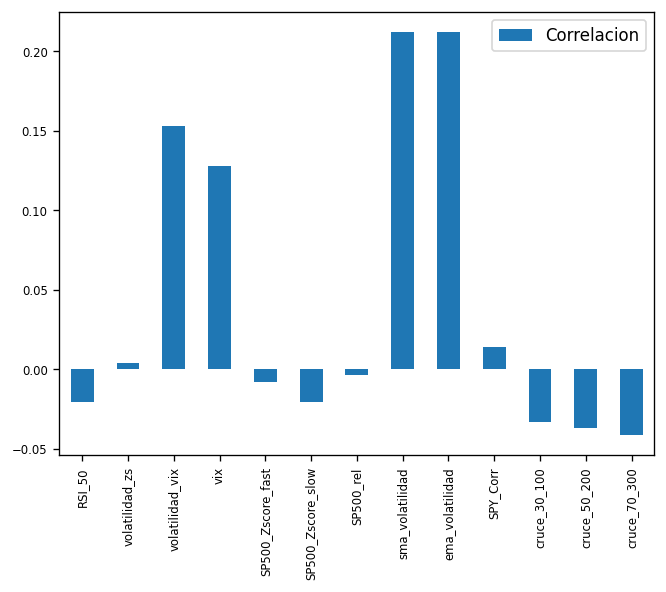

In [ ]:
data_train.dropna(inplace=True)
data_train = data_train.reset_index(drop=True)
features = data_train.iloc[:,3:]
target = data_train['fw']

corrs = {}
for feature in features.columns:
    corrs[feature] = features[feature].corr(target)

pd.DataFrame([corrs], index=['Correlacion']).T.plot(kind='bar')
pd.DataFrame([corrs], index=['Correlacion']).T.abs().mean()

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
pca = PCA()
pca_features = pca.fit_transform(scaled_features)
variance = pca.explained_variance_ratio_.cumsum()

pca = PCA(n_components=3) # Fijo directamente la cantidad de componentes que quiero
pca_features = pca.fit_transform(scaled_features)

new_features = pd.DataFrame(pca_features)
corrs = {}
for feature in new_features.columns:
    corrs[feature] = new_features[feature].corr(target.reset_index(drop=True))

display(pd.DataFrame([corrs], index=['Correlacion']))
pd.DataFrame([corrs], index=['Correlacion']).T.abs().mean()

,0,1,2
Correlacion,0.122673,0.137607,0.112068


,0
Correlacion,0.124116


In [ ]:
# Ahora si entrenamos con estos 3 features un nuevo arbol,
    # deberiamos validar con los datos de validacion escalados y reducidos
    # IMPORTANTE: No volver a fitear ni el escalado ni el PCA, solo transform

features_test = data_test.iloc[:,3:]

scaled_features_test = scaler.transform(features_test)
pca_features_test = pca.transform(scaled_features_test)

## Algos de Agrupamiento

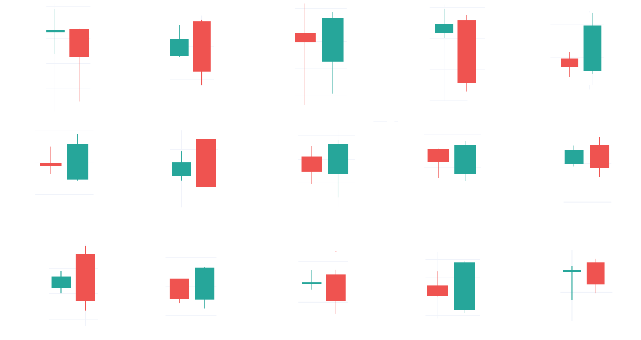

OUTPUT

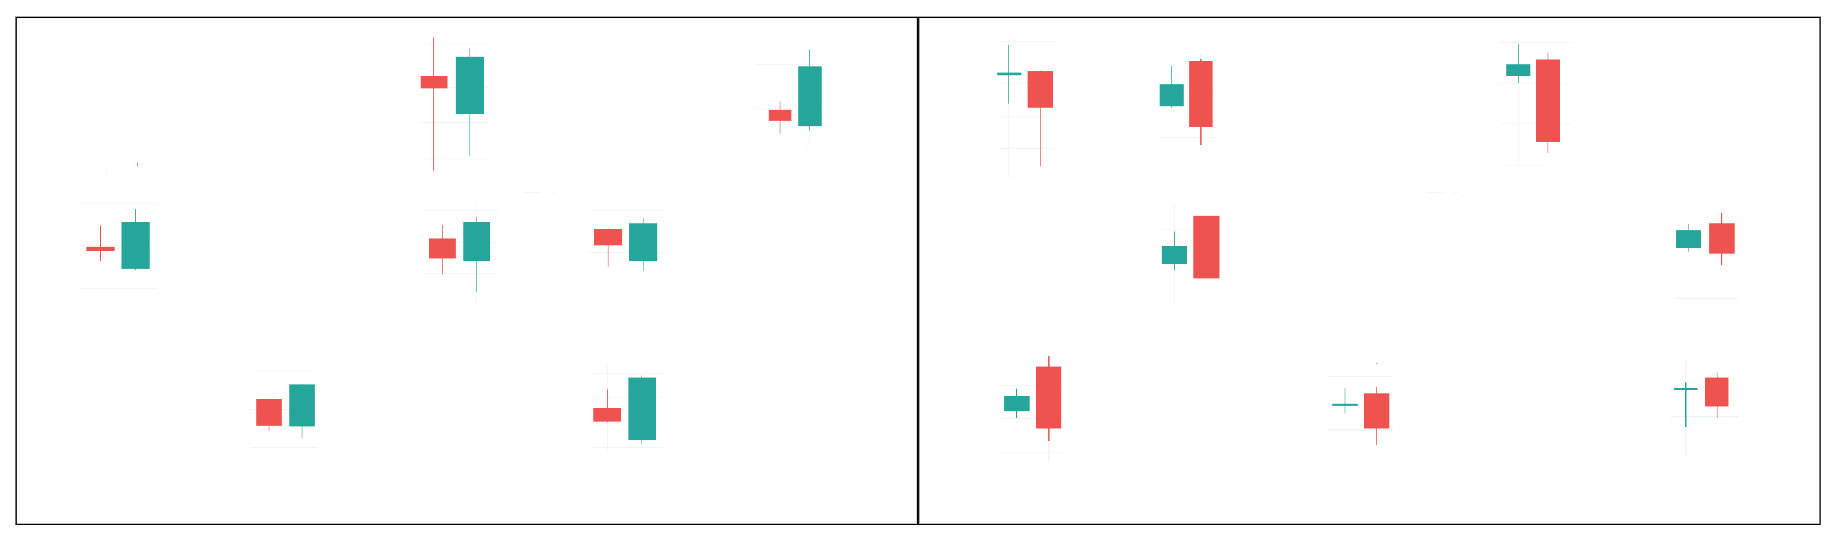

## Clusterizacion

### Presentacion del problema teorico

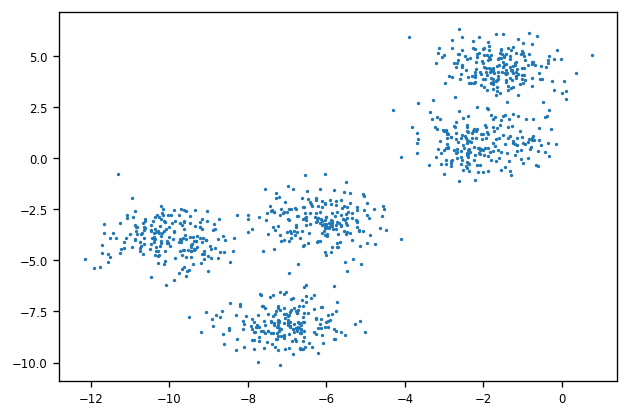

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=1000, centers=5, cluster_std=0.8, random_state=1)
fig, ax = plt.subplots(figsize=(6,4), nrows=1)
ax.scatter(X[:,0], X[:,1], s=1)
plt.show()

### Que vamos a buscar?

* Grupos que me diferencien bien los distintos tipos de datos
* COHESION (distancia intra cluster)
* SEPARACION (Distancia entre clusteres)

## Clustering Jerárquico

### Presentación del problema

In [ ]:
X, y = make_blobs(n_samples=50, centers=5, cluster_std=0.7, random_state=1)

def plotAll(X):
    fig, ax = plt.subplots(figsize=(7,7), nrows=1)
    ax.scatter(X[:,0], X[:,1], s=200, c='k', alpha=0.5)

    labels = range(len(X))
    for label, x, y in zip(labels, X[:, 0], X[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',
                     fontsize=10, ha='center', va='center', color='white')

    plt.show()

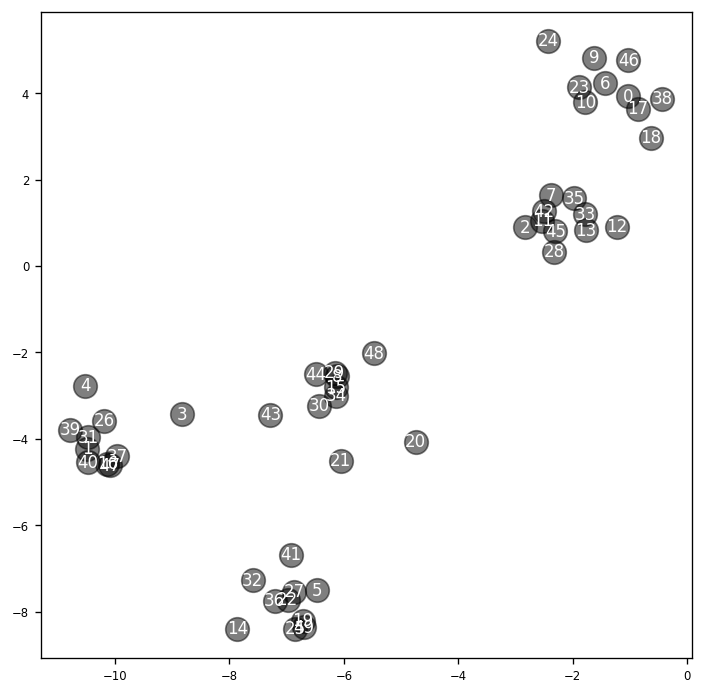

In [ ]:
plotAll(X)

In [ ]:
import matplotlib.pyplot as plt

def plotPointsIxds(X, idxs):
    puntos = [X[i] for i in idxs ]
    x = [p[0] for p in puntos]
    y = [p[1] for p in puntos]
    fig, ax = plt.subplots()
    ax.scatter(x, y, color='red', marker='o')
    for i, idx in enumerate(idxs):
        ax.annotate(f'Punto {idx}', (X[idx][0], X[idx][1]), textcoords="offset points", xytext=(0,5), ha='center')
    ax.grid(alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axis('equal')


def plotPoints(puntos):
    x = [p[0] for p in puntos]
    y = [p[1] for p in puntos]
    fig, ax = plt.subplots()
    ax.scatter(x, y, color='red', marker='o')
    for i, txt in enumerate(puntos):
        ax.annotate(f'({txt[0]}, {txt[1]})', (x[i], y[i]), textcoords="offset points", xytext=(0,5), ha='center')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.grid(alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [ ]:
X[1], X[31], X[39], X[40]

(array([-10.48187503,  -4.23107602]),
 array([-10.4675848 ,  -3.96221377]),
 array([-10.77982975,  -3.78925756]),
 array([-10.47873339,  -4.5449925 ]))

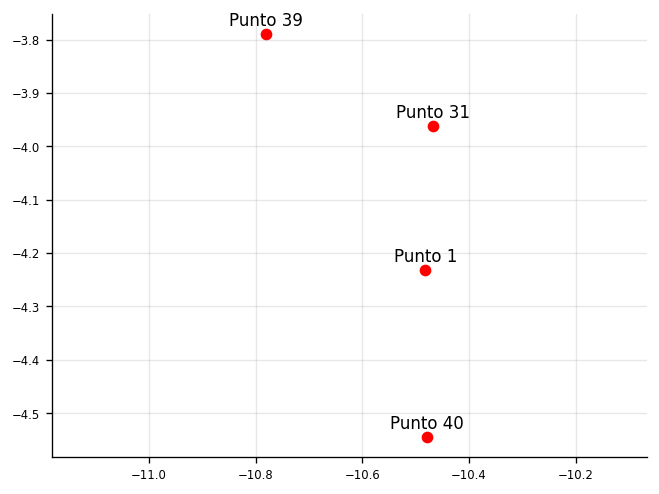

In [ ]:
plotPointsIxds(X, [1,31,39,40])

In [ ]:
from scipy.spatial.distance import pdist

# El 40 esta mas cerca del 1 que lo que esta el 39 del 31
# Por lo tanto con el criterio de unir primero al MAS CERCA A ALGUNO
    # => uniria primero el 40 al grupo 1-31 (antes que el 39)


pdist((X[1],X[40])), pdist((X[39],X[31]))

(array([0.3139322]), array([0.35694644]))

In [ ]:
# El 40 esta mas lejos del 31 que lo que esta el 39 del 1
# Por lo tanto con el criterio de unir primero al MENOS LEJOS A TODOS
    # => uniria primero el 39 al grupo 1-31 (antes que el 40)

pdist((X[1],X[39])), pdist((X[40],X[31]))

(array([0.53289827]), array([0.58288536]))

## Distancias en diferentes geometrías

### Euclidea

$$ {\displaystyle d(\mathbf {p} ,\mathbf {q} ) = {\sqrt {(p_{1}-q_{1})^{2}+(p_{2}-q_{2})^{2}+\cdots +(p_{n}-q_{n})^{2}}}={\sqrt {\sum _{i=1}^{n}(p_{i}-q_{i})^{2}}}} $$

### Canberra

Es menos sensible a las __diferencias extremas en una sola dimension__
<br>Toma un valor maximo que es el numero de dimensiones

$$ d(\mathbf {p} ,\mathbf {q} )=\sum _{i=1}^{n}{\frac {|p_{i}-q_{i}|}{|p_{i}|+|q_{i}|}} $$

### Chebyshev

Mide el mayor esfuerzo (distancia) en cualquiera de las dimensiones (en una sola)

$$ {\displaystyle d(\mathbf {p} ,\mathbf {q} ) = \max _{i}(|p_{i}-q_{i}|) } $$

### cityblock geometry (Manhattan)


$$ d(\mathbf {p} ,\mathbf {q} )=\sum _{i=1}^{n}|p_{i}-q_{i}| $$

### Geometrías no euclideas

* Hiperbolica
* Eliptica
* Otras

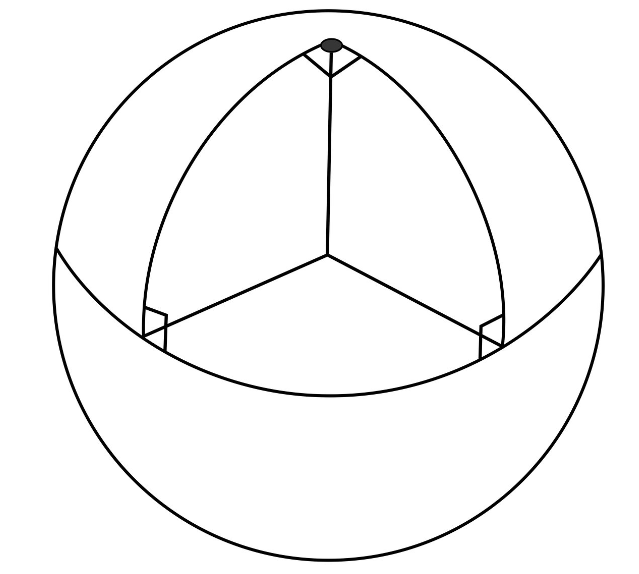

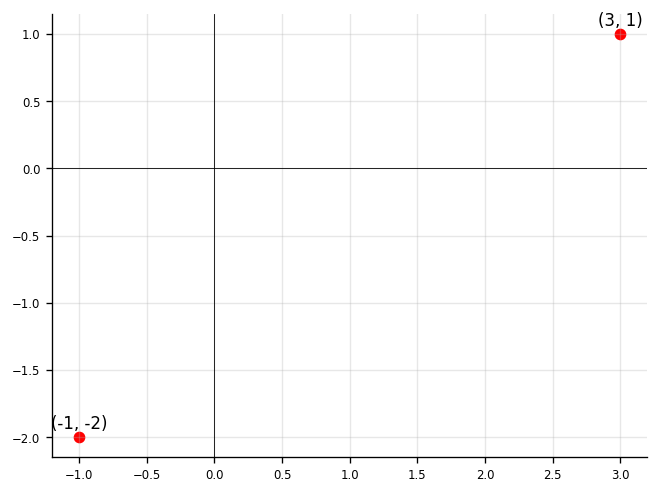

In [ ]:
plotPoints([(-1, -2), (3, 1)])

In [ ]:
from scipy.spatial.distance import pdist

puntos = ((-1,-2),(3,1))

tipos = ['euclidean', 'canberra', 'chebyshev', 'cityblock']
distancias = [pdist(puntos, metric=tipo)  for tipo in tipos]

dict(zip(tipos, distancias))

{'euclidean': array([5.]),
 'canberra': array([2.]),
 'chebyshev': array([4.]),
 'cityblock': array([7.])}

In [ ]:
from scipy.spatial.distance import pdist

puntos = ((1,2),(5,5))

tipos = ['euclidean', 'canberra', 'chebyshev', 'cityblock']
distancias = [pdist(puntos, metric=tipo)  for tipo in tipos]

dict(zip(tipos, distancias))

{'euclidean': array([5.]),
 'canberra': array([1.0952381]),
 'chebyshev': array([4.]),
 'cityblock': array([7.])}

In [ ]:
puntos = ((1,2),(6,2))

tipos = ['euclidean', 'canberra', 'chebyshev', 'cityblock']
distancias = [pdist(puntos, metric=tipo)  for tipo in tipos]

dict(zip(tipos, distancias))

{'euclidean': array([5.]),
 'canberra': array([0.71428571]),
 'chebyshev': array([5.]),
 'cityblock': array([5.])}

## Dendrogramas

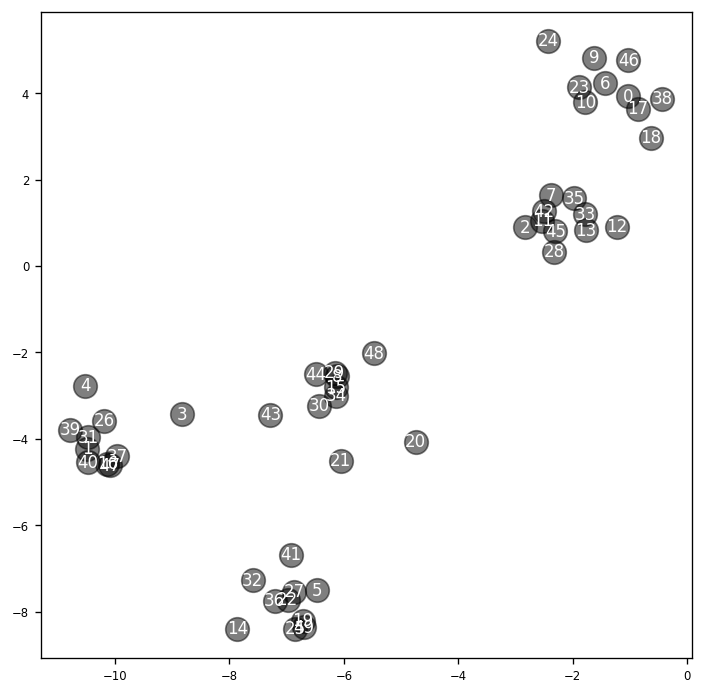

In [ ]:
plotAll(X)

### Euclideo: distancias mínimas

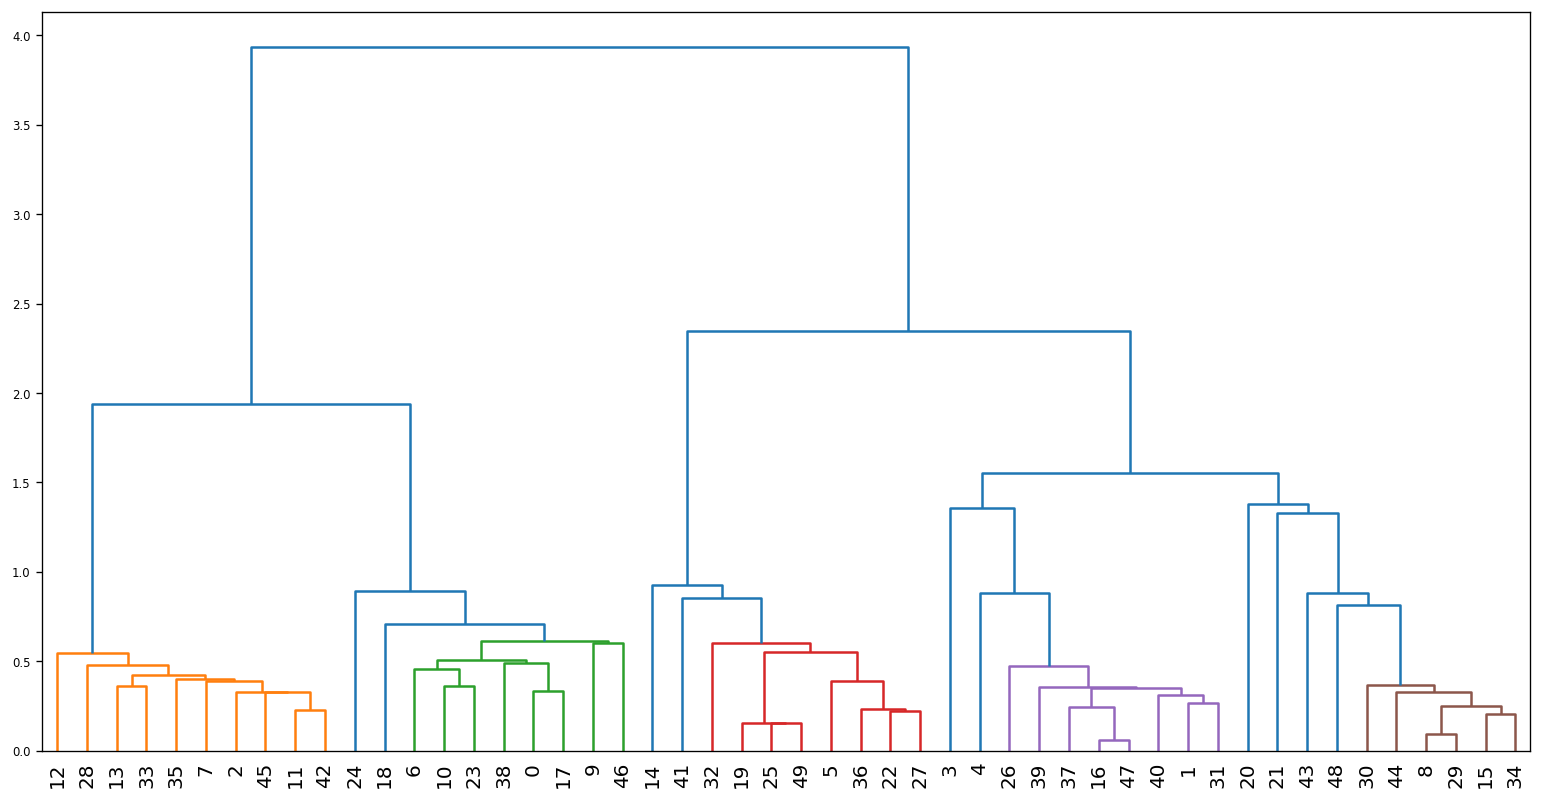

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# La minima distancia al valor mas cerca
agrupados = linkage(X, method='single', metric='euclidean')

labelList = range(len(X))

plt.figure(figsize=(16, 8))

dendrogram(agrupados, labels=labelList, leaf_font_size=12, color_threshold=0.7)

plt.show()

### Euclideo: distancias máximas

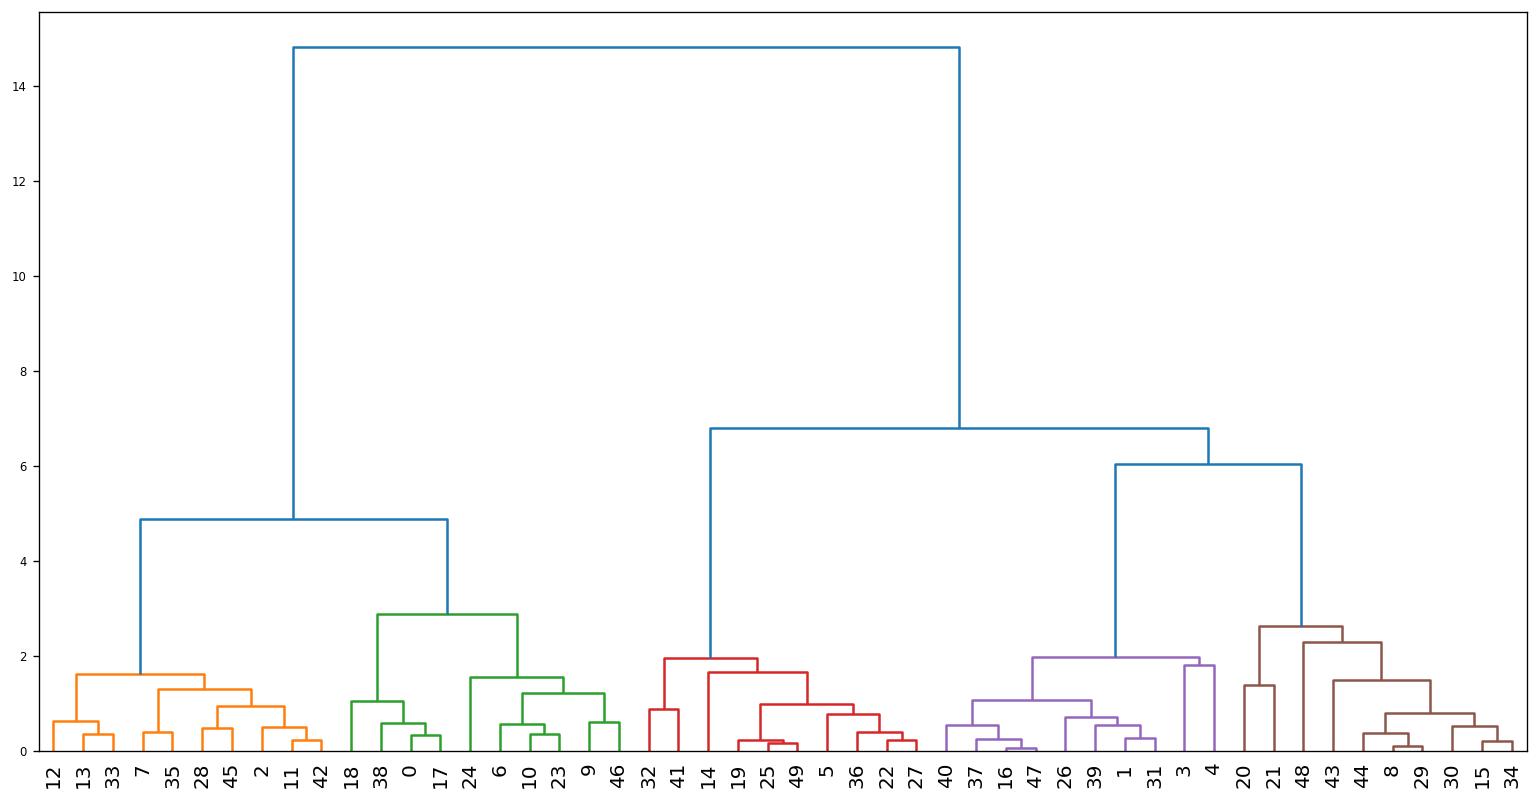

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# La minima distancia al punto mas lejano
agrupados = linkage(X, 'complete', metric='euclidean')

labelList = range(len(X))

plt.figure(figsize=(16, 8))

dendrogram(agrupados, labels=labelList, leaf_font_size=12, color_threshold=3)

plt.show()

### Euclideo: Por varianzas

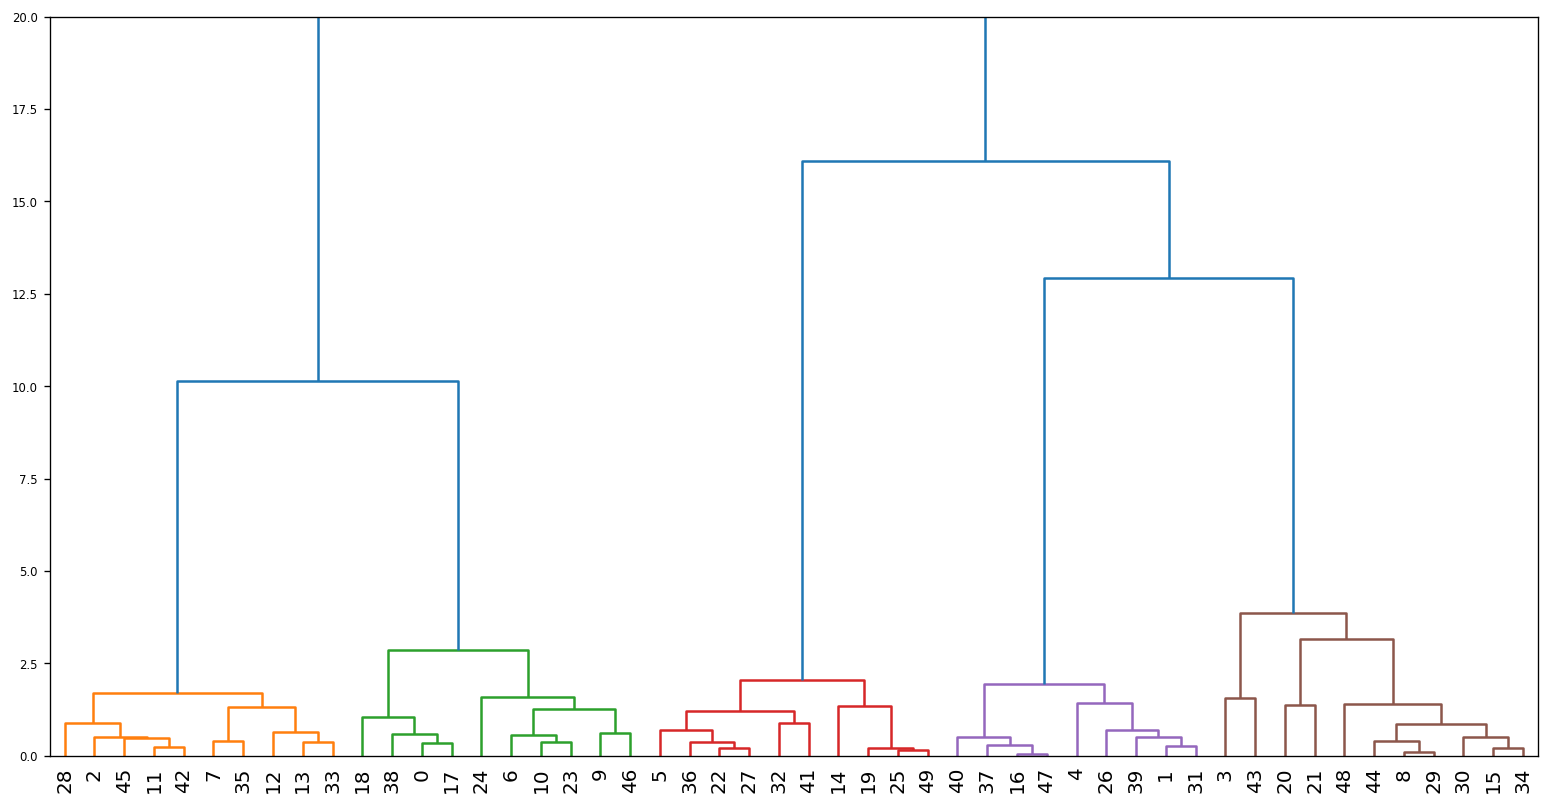

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))

# Miren lo que pasa con el punto "3" al tomar el zscore como criterio de minimizacion
agrupados = linkage(X, method='ward', metric='euclidean')

labelList = range(len(X))

dendrogram(agrupados, labels=labelList, leaf_font_size=12, color_threshold=5, ax=ax)
ax.set_ylim(0,20)

plt.show()

### Espacio Geométrico: Canberra

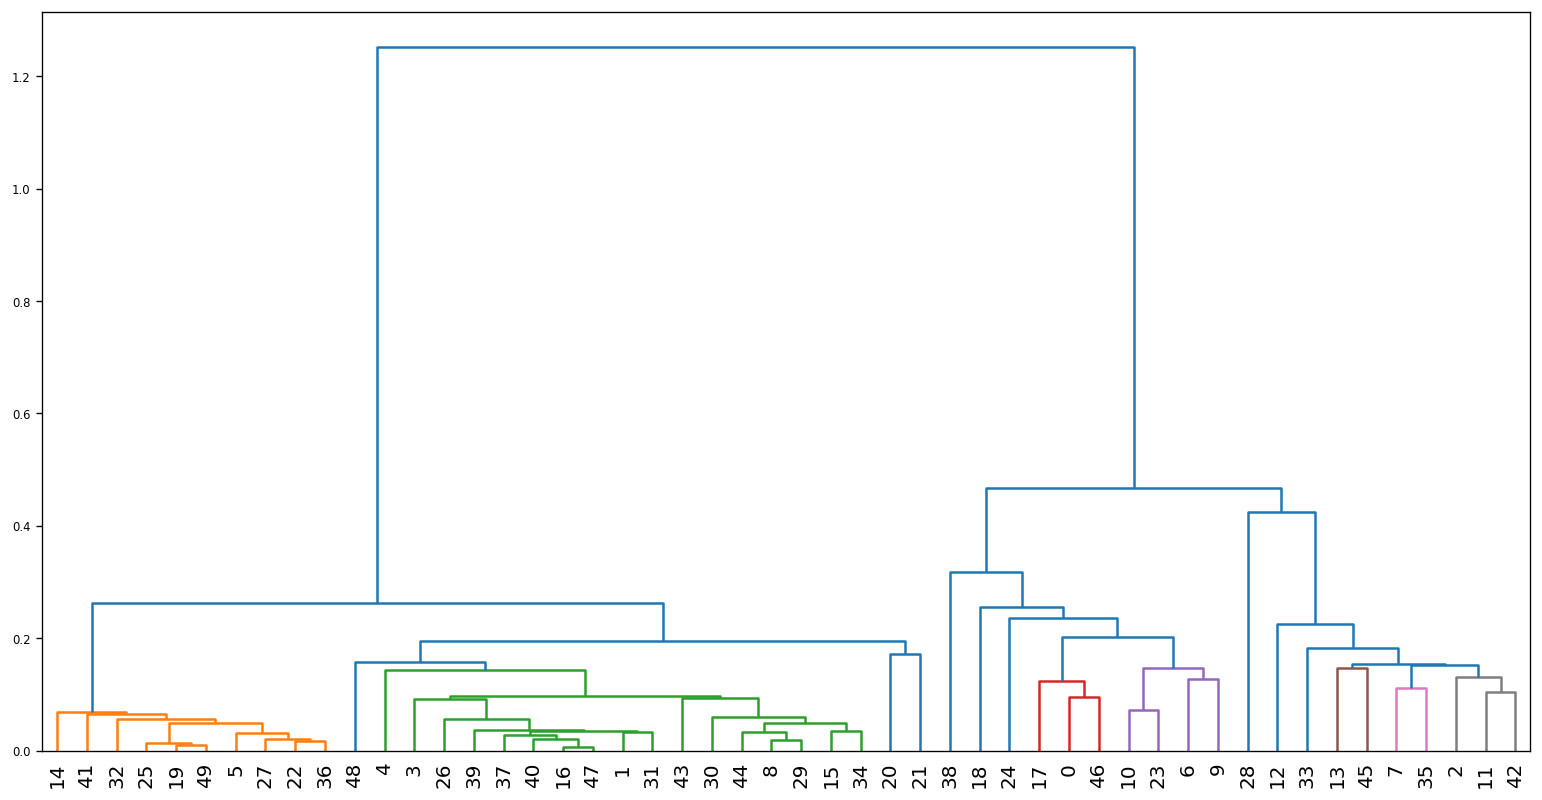

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

agrupados = linkage(X, 'single', metric='canberra')

labelList = range(len(X))

plt.figure(figsize=(16, 8))

dendrogram(agrupados, labels=labelList, leaf_font_size=12, color_threshold=0.15)

plt.show()

## Del dendograma a los clusters

In [ ]:
X, y = make_blobs(n_samples=50, centers=5, cluster_std=0.7, random_state=1)
agrupados = linkage(X, 'single', metric='euclidean')
clusters = fcluster(agrupados, t=1.5, criterion='distance')
clusters

array([2, 4, 1, 4, 4, 3, 2, 1, 5, 2, 2, 1, 1, 1, 3, 5, 4, 2, 2, 3, 5, 5,
       3, 2, 2, 3, 4, 3, 1, 5, 5, 4, 3, 1, 5, 1, 3, 4, 2, 4, 4, 3, 1, 5,
       5, 1, 2, 4, 5, 3], dtype=int32)

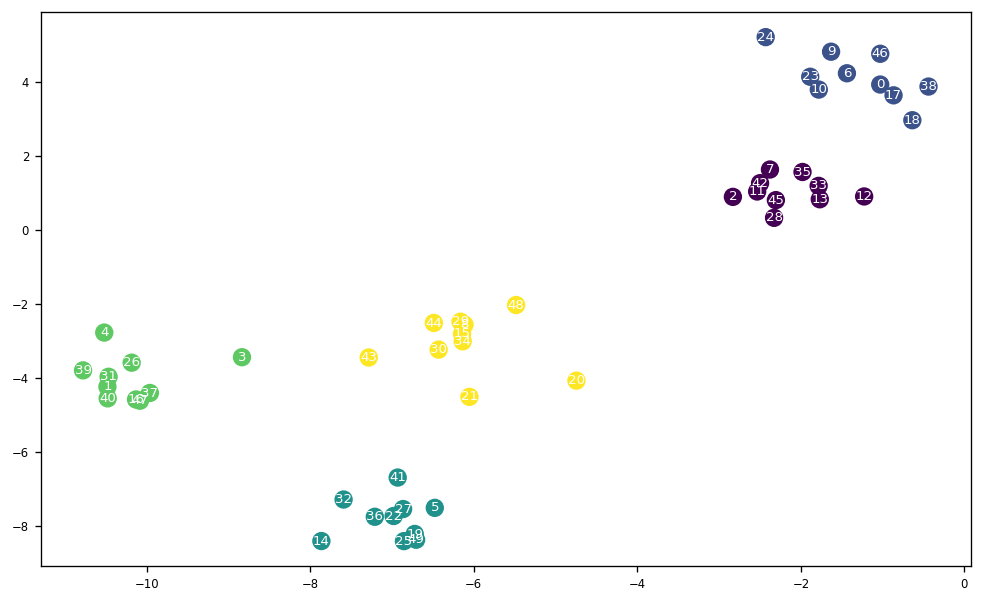

In [ ]:
X, y = make_blobs(n_samples=50, centers=5, cluster_std=0.7, random_state=1)
fig, ax = plt.subplots(figsize=(10,6), nrows=1)
ax.scatter(X[:,0], X[:,1], s=100, c=clusters, alpha=1)

labels = range(len(X))
for label, x, y in zip(labels, X[:, 0], X[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',
                 fontsize=8, ha='center', va='center', color='white')

plt.show()

## ¿Dónde es útil la clusterización jerárquica?

* Segmentacion de clientes
* Busqueda de nichos de mercado
* Deteccion de fraudes
* Busqueda de grupos similares en general en conjuntos de hasta 10k datos


Hasta 10k conglomerados iniciales (cantidad de datos inicial), es muy eficiente este algoritmo, mas de esa cantidad empieza a ser ineficiente y conviene migrar a otro tipo de algoritmo

## Aplicación de clustering jerárquico en la bolsa

### API FMP - Obtención de datos

Sitio de FMP API:  https://fmpcloud.io/

* ETFs (424)
* Commodities (28)
* Equity Europa: Euronext (1248)
* Equity Nyse (4380)
* Equity Amex (274)
* Equity Nasdaq (3825)
* Equity Canadá: TSX (1413)
* Indices (56)
* Fondos Mutuales (1504)

In [ ]:
apikey = '66c44b016256f8b9e507838f32434ece'

import requests
import pandas as pd

def screenMktCapHigh(minMktCap= 10**10):
    url = 'https://fmpcloud.io/api/v3/stock-screener'
    p = {'apikey': apikey, 'marketCapMoreThan':minMktCap }
    r = requests.get(url, params = p)
    js = r.json()
    df = pd.DataFrame(js)
    return df

data = screenMktCapHigh().drop('companyName', axis=1)
data.iloc[:,:-4]

,symbol,marketCap,sector,industry,beta,price,lastAnnualDividend,volume,exchange,exchangeShortName
0,LTM,11451077910,Industrials,"Airlines, Airports & Air Services",1.226,37.89,0.63632,328586,New York Stock Exchange,NYSE
1,TSM,1010541580960,Technology,Semiconductors,1.321,194.84,2.46967,6808687,New York Stock Exchange,NYSE
2,MSFT,3433610503800,Technology,Software - Infrastructure,0.985,461.97,3.24000,16546045,NASDAQ Global Select,NASDAQ
3,NVDA,3352072000000,Technology,Semiconductors,2.122,137.38,0.04000,194624958,NASDAQ Global Select,NASDAQ
4,BCH,15258617850,Financial Services,Banks - Regional,0.145,30.21,2.10369,737753,New York Stock Exchange,NYSE
...,...,...,...,...,...,...,...,...,...,...
995,EXEEZ,27636550584,Energy,Oil & Gas Energy,0.440,107.24,0.00000,2,NASDAQ Capital Market,NASDAQ
996,VSBSX,27609582478,Financial Services,Asset Management - Leveraged,0.260,19.48,0.74190,0,NASDAQ,NASDAQ
997,BMLP,27603392492,Financial Services,Asset Management,1.740,42.33,0.00000,130,NASDAQ Global Market,NASDAQ
998,VOT,27594752261,Financial Services,Asset Management,1.150,270.07,1.74520,195490,New York Stock Exchange Arca,AMEX


In [ ]:
data.groupby('exchangeShortName').size()

,0
exchangeShortName,
AMEX,81
EURONEXT,33
NASDAQ,445
NYSE,377
TSX,64


In [ ]:
data['div_yield'] = data['lastAnnualDividend'] / data['price']
data['vol_mln'] = data['price'] * data['volume'] / 1000000

df = data.loc[(data.exchangeShortName=='NASDAQ')]
df = df.loc[df.country=='US'].reset_index()
df = df.loc[:100,['symbol','marketCap','beta','div_yield','vol_mln']]
df

,symbol,marketCap,beta,div_yield,vol_mln
0,MSFT,3430487350492,0.985,0.007020,4928.686771
1,NVDA,3352926000000,2.122,0.000291,21126.314980
2,AAPL,3010444912200,1.211,0.005011,5304.411675
3,VSMPX,2244594368325,1.020,0.012924,0.000000
4,AMZN,2195721005400,1.308,0.000000,4653.951704
...,...,...,...,...,...
96,AMECX,127446614009,0.900,0.038314,0.000000
97,RIDGX,127446613999,0.900,0.041271,0.000000
98,IFAFX,127446613996,0.900,0.037769,0.000000
99,AEPGX,126487904236,1.030,0.010774,0.000000


### Praparamos datos para Clusterizacion

In [ ]:
data = screenMktCapHigh()
data['div_yield'] = data['lastAnnualDividend'] / data['price']
data['vol_mln'] = data['price'] * data['volume'] / 1000000

df = data.loc[(data.exchangeShortName=='NASDAQ')].copy().reset_index()
df = df.loc[(df.vol_mln > 300)]

df = df.loc[:,['symbol','marketCap','beta','div_yield','vol_mln']].dropna()
df

,symbol,marketCap,beta,div_yield,vol_mln
0,MSFT,3431232091000,0.985,0.007018,4939.936145
1,NVDA,3355610000000,2.122,0.000291,21205.335252
2,AAPL,3010444912200,1.211,0.005011,5304.411675
4,AMZN,2195721005400,1.308,0.000000,4653.951704
5,GOOG,2059108149643,1.010,0.004698,2837.863212
...,...,...,...,...,...
329,TTWO,40186762500,1.086,0.000000,426.809352
353,LULU,37170109200,1.301,0.000000,459.763247
361,EA,36537910183,0.746,0.005216,368.710506
372,IEF,34692344222,1.150,0.037325,1093.978097


In [ ]:
valores = df.iloc[:,[1,2,3,4]].values
valores[:5]

array([[3.43123209e+12, 9.85000000e-01, 7.01830391e-03, 4.93993614e+03],
       [3.35561000e+12, 2.12200000e+00, 2.90856208e-04, 2.12053353e+04],
       [3.01044491e+12, 1.21100000e+00, 5.01093972e-03, 5.30441168e+03],
       [2.19572101e+12, 1.30800000e+00, 0.00000000e+00, 4.65395170e+03],
       [2.05910815e+12, 1.01000000e+00, 4.69800628e-03, 2.83786321e+03]])

### Escalamos

In [ ]:
from sklearn.preprocessing import StandardScaler
escalar = StandardScaler()

valores_esc = escalar.fit_transform(valores)
print(valores_esc[:5])

[[ 4.17241385 -0.43712532 -0.2030978   0.61321625]
 [ 4.06930335  1.0667709  -0.70932242  4.25572549]
 [ 3.59867176 -0.13819784 -0.35414724  0.69483771]
 [ 2.4877981  -0.00989711 -0.73120867  0.54917227]
 [ 2.30152687 -0.40405812 -0.37769474  0.14247342]]


### Armamos Dendograma

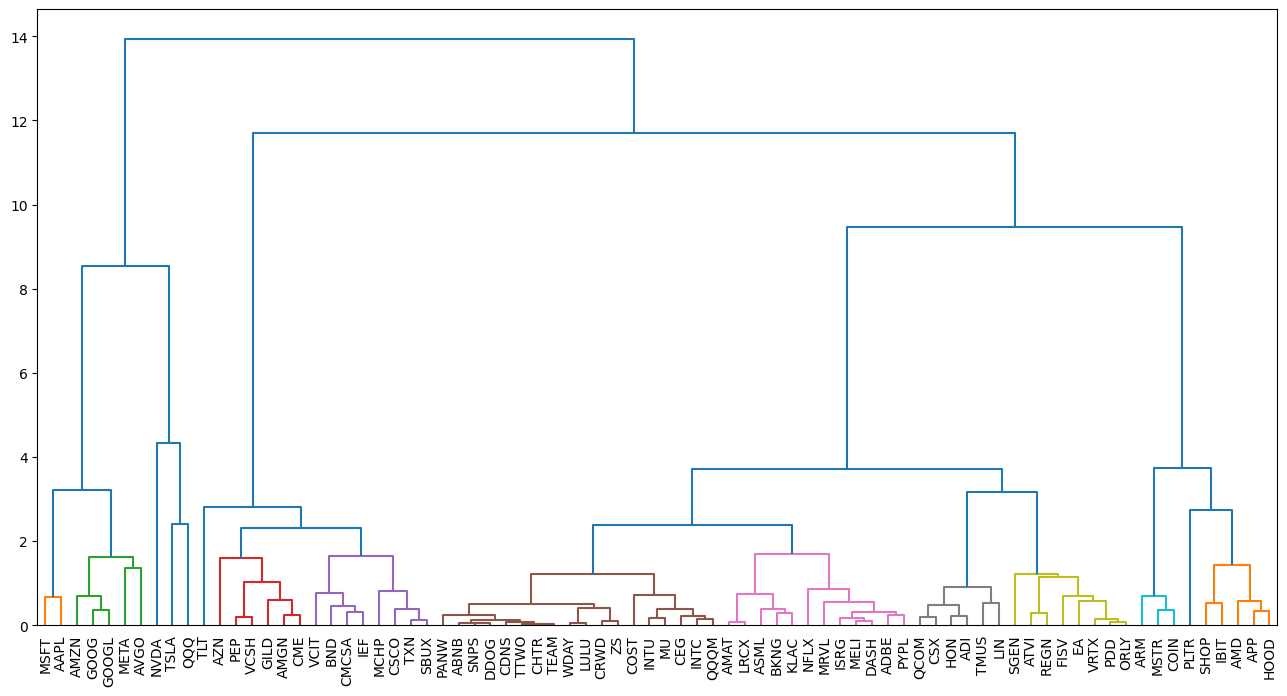

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Algunas configs similares method/t: ward/1,5, average/0,8, weighted/0.7, median/0.7
# metodos: ward, single, median, centroid, weighted, complete, average

clusterizado = linkage(valores_esc, method = 'ward')
labels = df.iloc[:,0].values

fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(clusterizado, labels=labels, color_threshold=2, leaf_font_size=10, ax=ax)
#ax.set_ylim(0,8)


plt.show()

### Asignamos clusteres a partir de dendograma

In [ ]:
clusters = fcluster(clusterizado, t=1.5, criterion='distance')
clusters

array([ 1,  6,  1,  2,  2,  2,  2, 20,  3, 20, 20,  7,  5, 22, 16,  9, 17,
       12, 22, 22,  4, 19, 11, 21, 19, 19,  9, 10, 11, 10, 14, 17, 12, 14,
       10, 15, 19,  7, 18, 21, 18, 17, 17, 10, 22, 11, 21, 15, 21, 22,  9,
       12, 22, 19, 12, 10, 22, 18, 18, 17, 18, 16, 21, 18, 19, 18, 19, 15,
       17, 22, 10, 18, 14,  9, 15, 11, 18, 18,  7, 16, 19,  8, 18, 10, 22,
        9, 22, 12, 11, 22, 17, 18, 12, 22, 19, 18, 18, 22, 17,  7,  7, 18,
        9, 18, 17,  7, 21, 10, 19, 19, 22, 13,  7, 17, 17, 18, 16],
      dtype=int32)

In [ ]:
df['cluster']  = clusters
df

,symbol,marketCap,beta,div_yield,vol_mln,cluster
0,MSFT,3421644114400,0.985,0.007038,16006.935871,1
1,NVDA,3297172000000,2.114,0.000296,45021.377096,6
2,AAPL,2999855430000,1.275,0.005029,14224.185351,1
4,AMZN,2176468164000,1.308,0.000000,10594.795024,2
5,GOOGL,2090065647762,1.010,0.004658,9040.378315,2
...,...,...,...,...,...,...
400,MCHP,31288436400,1.407,0.031359,629.112136,7
403,CSGP,31034007720,0.893,0.000000,452.186340,17
404,LPLA,30963392012,0.643,0.003099,462.382091,17
425,ANSS,29084404202,1.214,0.000000,915.138103,18


<Axes: xlabel='cluster'>

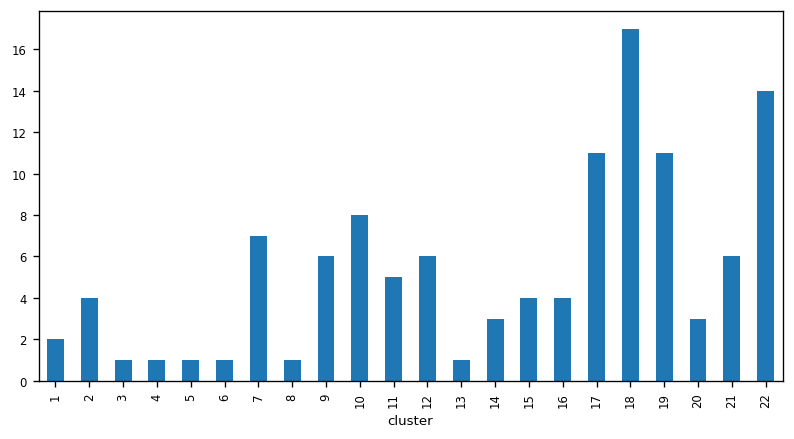

In [ ]:
df['cluster']  = clusters
df.groupby('cluster').size().plot(kind='bar', figsize=(8,4))

In [ ]:
df.head(15)

,symbol,marketCap,beta,div_yield,vol_mln,cluster
0,MSFT,3421644114400,0.985,0.007038,16006.935871,1
1,NVDA,3297172000000,2.114,0.000296,45021.377096,6
2,AAPL,2999855430000,1.275,0.005029,14224.185351,1
4,AMZN,2176468164000,1.308,0.000000,10594.795024,2
5,GOOGL,2090065647762,1.010,0.004658,9040.378315,2
6,GOOG,2089462072841,1.010,0.004628,6267.239204,2
7,META,1627885630893,1.237,0.003127,10515.853363,2
11,AVGO,1138201036500,1.059,0.009233,6557.327477,20
12,TSLA,1114395519200,2.434,0.000000,42779.127019,3
14,NFLX,513762078330,1.585,0.000000,5670.064746,20


### Implementamos los Clusteres en la matriz escalada para reporting grafico

In [ ]:
df_esc = pd.DataFrame(valores_esc)
df_esc.columns=df.columns[1:-1]
df_esc['cluster'] = clusters
df_esc['simbolo'] = labels

cantidades = df_esc.groupby('cluster').size()
cantidades.sort_values(ascending=False)

,0
cluster,
18,17
22,14
19,11
17,11
10,8
7,7
21,6
12,6
9,6


In [ ]:
clusteres_grandes = list(cantidades.sort_values(ascending=False).index)[:6]
clusteres_grandes

[18, 22, 19, 17, 10, 7]

### Reporte Visual del clusterizado

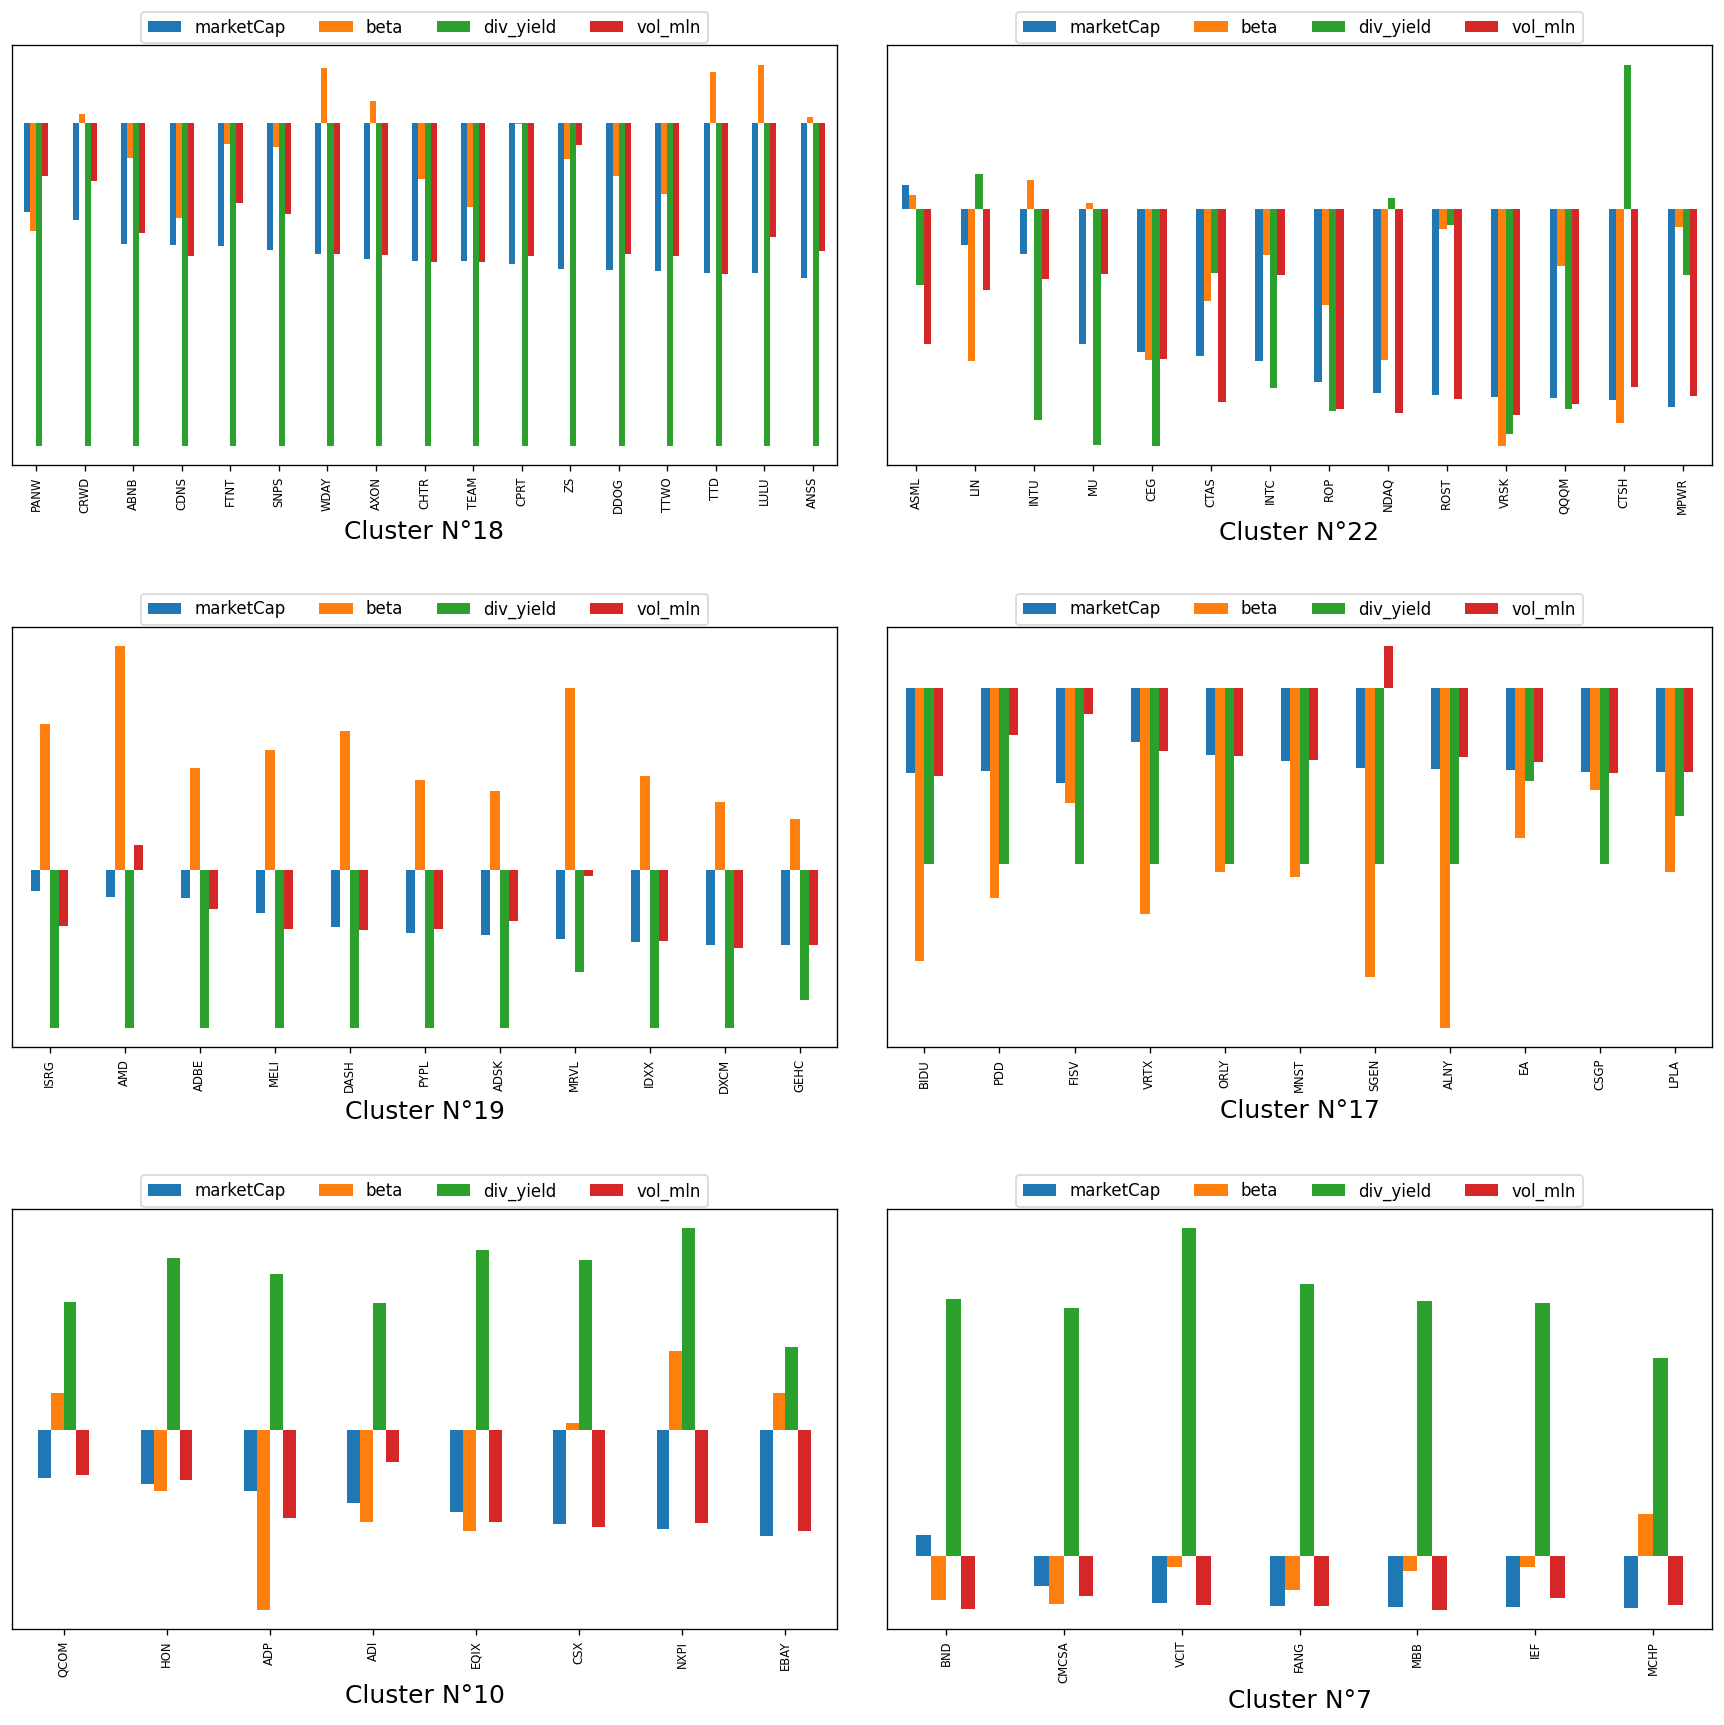

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120
columnas = 2
fig, ax = plt.subplots(figsize=(15,15), ncols=columnas, nrows=3)

for i in range(len(clusteres_grandes)):
    col = i % columnas
    row = i // columnas
    cluster = clusteres_grandes[i]
    grupo = df_esc.loc[df_esc.cluster==cluster].drop(['cluster'], axis=1).set_index('simbolo')
    grupo.plot(kind='bar', ax=ax[row][col])
    ax[row][col].axes.yaxis.set_visible(False)
    ax[row][col].set_xlabel('Cluster N°'+str(cluster), fontsize=15)
    ax[row][col].legend(ncol=4, bbox_to_anchor=(0.5,1.1), loc='upper center')

fig.tight_layout(pad=3.0)
plt.show()

### Reporte cuantitativo del clusterizado

In [ ]:
cant = df.groupby('cluster').size()
medias = df.iloc[:,1:].groupby('cluster').mean()
medias['cantidades'] = cant
medias = medias.sort_values('cantidades', ascending=False)
medias

,marketCap,beta,div_yield,vol_mln,cantidades
cluster,,,,,
18,6.263208e+10,1.166235,0.000000,1216.877103,17
22,1.008052e+11,1.094143,0.008278,1099.858959,14
19,9.670224e+10,1.605364,0.000543,1432.386264,11
17,4.523984e+10,0.576030,0.000762,1308.389777,11
10,9.646570e+10,1.121875,0.018753,1275.783543,8
7,9.706207e+10,1.118429,0.037591,680.453153,7
21,1.024866e+11,1.480667,0.009077,1220.266919,6
12,1.352703e+11,0.447333,0.026411,719.075373,6
9,1.086776e+11,0.946833,0.026242,1010.129616,6


# Ejemplo clusterizacion un poco mas grande

In [ ]:
data = screenMktCapHigh()
data

,symbol,companyName,marketCap,sector,industry,beta,price,lastAnnualDividend,volume,exchange,exchangeShortName,country,isEtf,isFund,isActivelyTrading
0,LTM,LATAM Airlines Group S.A.,11438989150,Industrials,"Airlines, Airports & Air Services",1.226,37.85,0.63632,275463,New York Stock Exchange,NYSE,CL,False,False,True
1,TSM,Taiwan Semiconductor Manufacturing Company Lim...,1002658070372,Technology,Semiconductors,1.321,193.32,2.46967,11976504,New York Stock Exchange,NYSE,TW,False,False,True
2,MSFT,Microsoft Corporation,3421644114400,Technology,Software - Infrastructure,0.985,460.36,3.24000,34770475,NASDAQ Global Select,NASDAQ,US,False,False,True
3,NVDA,NVIDIA Corporation,3297172000000,Technology,Semiconductors,2.114,135.13,0.04000,333170851,NASDAQ Global Select,NASDAQ,US,False,False,True
4,BCH,Banco de Chile,15258617850,Financial Services,Banks - Regional,0.145,30.21,2.10369,717216,New York Stock Exchange,NYSE,CL,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,FSNVX,Fidelity Freedom 2040 K,27611015164,None,None,1.240,11.95,0.49500,0,NASDAQ,NASDAQ,US,False,True,True
996,FFFFX,Fidelity Freedom 2040,27611015164,,,1.240,11.96,0.47400,0,NASDAQ,NASDAQ,US,True,True,True
997,BMLP,BMO Dorsey Wright MLP Index Exchange Traded Notes,27603392492,Financial Services,Asset Management,1.740,42.33,0.00000,130,NASDAQ Global Market,NASDAQ,US,True,False,False
998,BCE.TO,BCE Inc.,27562567500,Communication Services,Telecommunications Services,0.665,29.90,3.99000,5134167,Toronto Stock Exchange,TSX,CA,False,False,True


In [ ]:
data = screenMktCapHigh()
data['div_yield'] = data['lastAnnualDividend'] / data['price']
data['vol_mln'] = data['price'] * data['volume'] / 1000000

df = data.loc[(data.exchangeShortName=='NASDAQ')].copy().reset_index()
df = df.loc[(df.vol_mln > 300)].dropna()

df = df.loc[:500,['symbol','marketCap','beta','div_yield','vol_mln']]

valores = df.iloc[:,[1,2,3,4]].values
valores_esc = StandardScaler().fit_transform(valores)
clusterizado = linkage(valores_esc, method = 'ward')
clusters = fcluster(clusterizado, t=1.5, criterion='distance')
df['cluster']  = clusters

df_esc = pd.DataFrame(valores_esc)
df_esc.columns=df.columns[1:-1]
df_esc['cluster'] = clusters
df_esc['simbolo'] = df.iloc[:,0].values

In [ ]:
cantidades = df_esc.groupby('cluster').size()
cantidades.sort_values(ascending=False)

,0
cluster,
18,17
22,14
19,11
17,11
10,8
7,7
21,6
12,6
9,6


In [ ]:
clusteres_grandes = list(cantidades.sort_values(ascending=False).index)[:6]

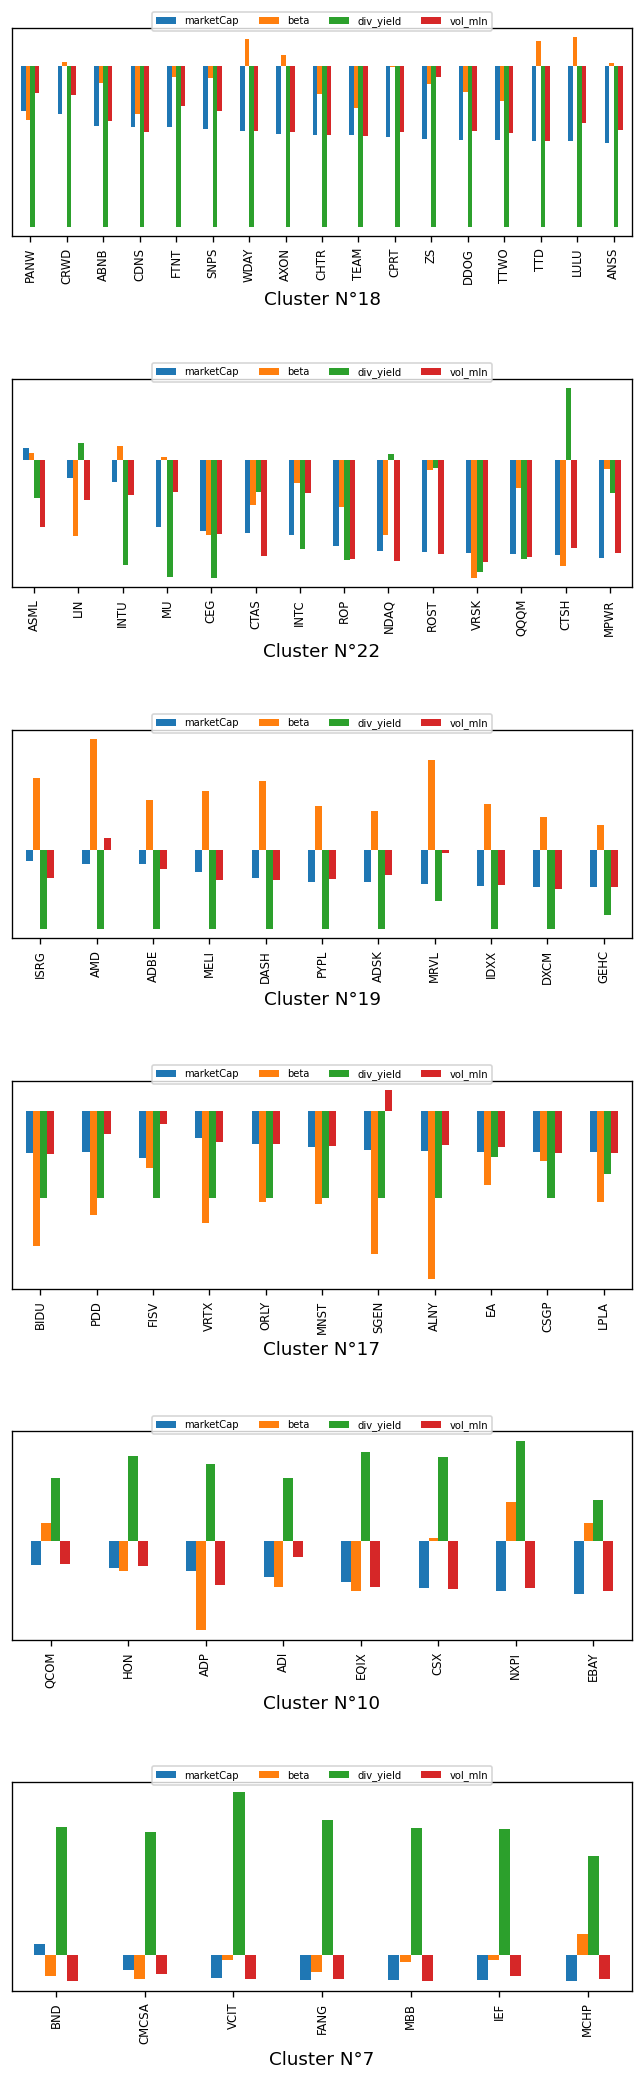

In [ ]:
columnas = 1
fig, ax = plt.subplots(figsize=(6,18), nrows=len(clusteres_grandes))

for i in range(len(clusteres_grandes)):
    cluster = clusteres_grandes[i]
    grupo = df_esc.loc[df_esc.cluster==cluster].drop(['cluster'], axis=1).set_index('simbolo')
    grupo.plot(kind='bar', ax=ax[i])
    ax[i].axes.yaxis.set_visible(False)
    ax[i].set_xlabel('Cluster N°'+str(cluster), fontsize=11)
    ax[i].legend(ncol=4, bbox_to_anchor=(0.5,1.1), loc='upper center', fontsize=6)

fig.tight_layout(pad=3.0)
plt.show()

<Axes: xlabel='cluster'>

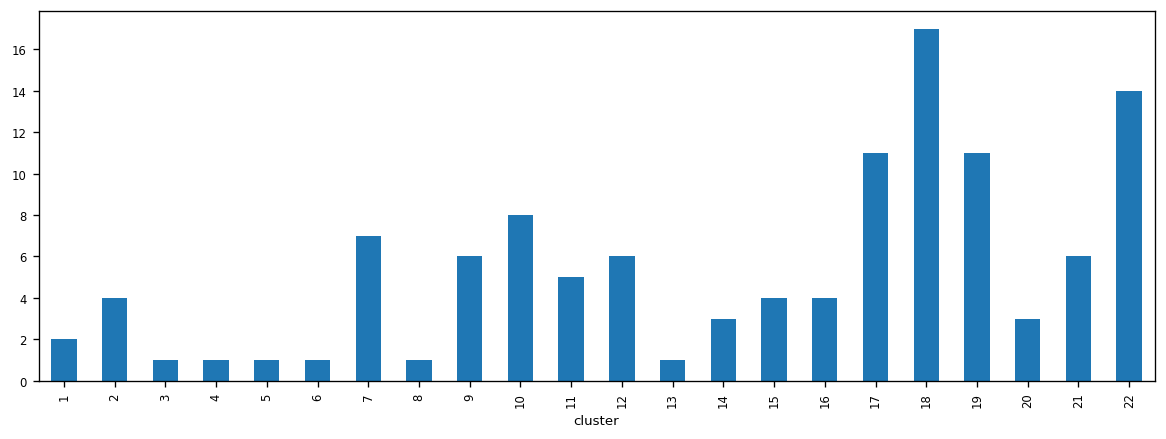

In [ ]:
df.groupby('cluster').size().plot(kind='bar', figsize=(12,4))

In [ ]:
df.iloc[:,1:].groupby('cluster').mean().sort_values('beta')

,marketCap,beta,div_yield,vol_mln
cluster,,,,
13,3.163602e+10,0.268000,0.074822,468.295353
12,1.352703e+11,0.447333,0.026411,719.075373
11,1.077699e+11,0.478400,0.036332,1192.146169
16,1.072436e+11,0.479250,0.013001,1592.864827
17,4.523984e+10,0.576030,0.000762,1308.389777
9,1.086776e+11,0.946833,0.026242,1010.129616
22,1.008052e+11,1.094143,0.008278,1099.858959
7,9.706207e+10,1.118429,0.037591,680.453153
10,9.646570e+10,1.121875,0.018753,1275.783543
